### Для просмтора всех визуализаций необходимо октрыть ноутбук в Jupyter

### Импорт необходимых библиотек


In [46]:
# !pip install catboost
# ! pip install shap
# ! pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

In [45]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import shap

from catboost.utils import get_roc_curve
from catboost import CatBoostClassifier
from catboost import Pool

from scipy import stats

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc


## Пожалуй, только моя вина в том, что я не стал последовательно тренировать модели после проделанных ниже манипуляций (стандартизация, распределение весов каждого класса, grid_search) и фиксировать это в каждой ячейке сверху вниз, а не в отдельных записях у себя (осознаю ошибку и исправлю при продолжение работы в дипломе). Поэтому, я сейчас опишу что я сделал и как это сказалось на модели 

## Шаг 1

#### Первоначально установил параметр модели ***loss_function='Logloss'***, так как задача классификации

#### Установил лучшее значение  параметра iterations в рамках метода тыка только этого параметра
#### Установил  значение learning_rate в рамках метода тыка, нотолько с учетом iterations
#### Установил random_state=42 для тренировки всегда только на 1 разбиение
#### Установил eval_metric='AUC'

### В результате, AUC вырос на 0.003% процента, recall и precision изменились в рамках погрешности

## Шаг 2

#### Стандартизировал числовые признаки (ниже в коде описал для чего)

#### Задал веса каждому классу при помощи class_weight (ниже описано что это)

### В результате значения AUC выросло на 0.002, recall + ~ 0.07 (для минорного класса, который был ~ 0) и precision + ~ 0.40 (для минорного класса, который был ~ 0). Также, 2 последние метрики снизились в рамках ~ 0.1 - 0.2 для мажорного класса

## Шаг 3

#### Провел кросс-валидацию по 5 фолдами

### В результате осознал ошибку того, что данную процедуру стоило провести после тюнинга и грид сеча. Модель выдала в среднем AUC ~ 0.70 

## Шаг 4


#### Провел gread_search с заданными вручную параметрами

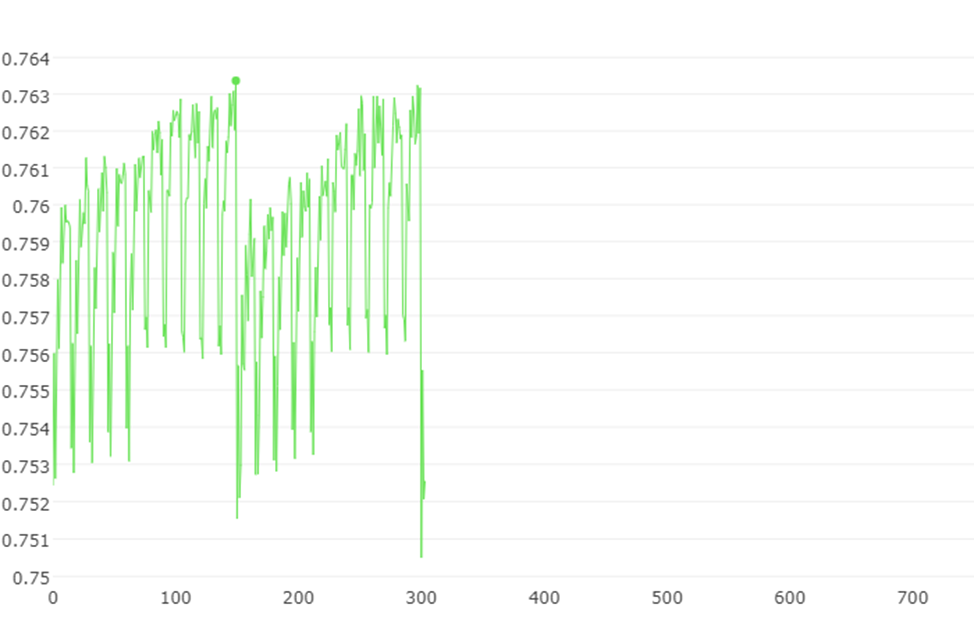

#### на момент последней операции  прошло 18 часов и оставлось 27 часов.

#### В силу внешних обстоятельст я не мог более ждать результат процедуры и решил зификсировать максимальное значение метрики AUC и парметры, при которых было достигнуто данное значение.

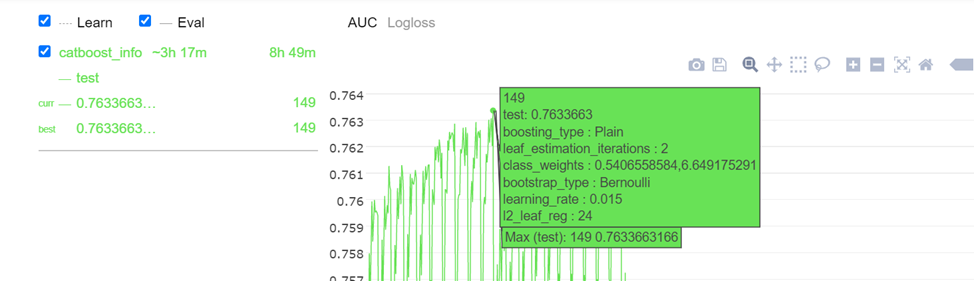

### В реузльтате подстановки параметров, AUC вырос на 0.00004%, но precall для минорного класса значительно вырос, вместе с тем упал precision для мажорного класса

#### Classification_report до стандартизации, задания весов, грид сеча

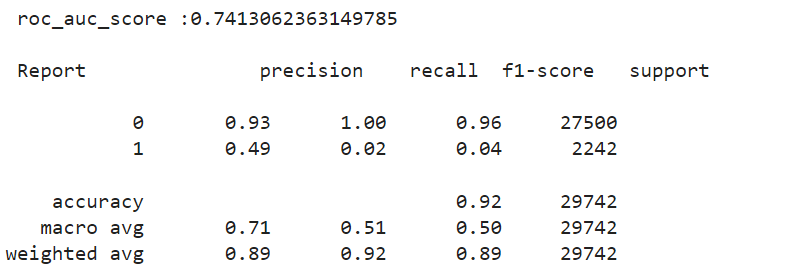

#### Classification_report после 

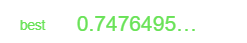

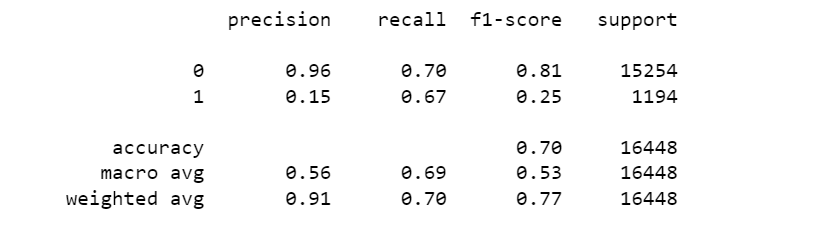

### В результате

#### Precision - доля объектов, названных классификатором положительными и при этом действительно являющимися положительными уменьшилось, а recall - доля объектов положительного класса из всех объектов положительного класса нашел алгоритм вырос.

#### Также, упала предскательная способность для мажорного класса 

#### В рамках дипломной работы я рассмортю другие методы борьбы с дисбалансом, с целью увеличить предсказательную способность модели для миного класса еще выше

# Ниже, будет представлена интрепретация модели отдельной главой

###### (ниже, я описываю действия во время всех шагов выше)

### Загрузка данных, предобработанных в другом ноутбуке

In [17]:
df_test = pd.read_csv('C:/Users/kail/Desktop/Универ/4 курс/Курсовая/Jup/X_test_.csv',sep = ';' )
df_train = pd.read_csv('C:/Users/kail/Desktop/Универ/4 курс/Курсовая/Jup/X_train_.csv',sep = ';')

In [18]:
# Дополнительная проверка на пропущенные значения
print(f'Количество пропусков train: {df_train.isnull().sum().sort_values(ascending = False).sum()}')
print(f'Количество пропусков test: {df_test.isnull().sum().sort_values(ascending = False).sum()}')

Количество пропусков train: 0
Количество пропусков test: 0


In [19]:
df_train.head(1)

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [20]:
df_test.head(1)

,Unnamed: 0,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,...,0,0,0,0,0,0,0,0,0,0


####  Удалю столбец, который появился при экспорте из предыдущего ноутбука
#### и SK_ID_CURR  (уже обосновывал свое решение ранее)

In [21]:
df_train = df_train.drop(['Unnamed: 0','SK_ID_CURR'],axis = 1)

In [22]:
df_test = df_test.drop(['Unnamed: 0','SK_ID_CURR'],axis = 1)

##### Создам список числовых признаков для стандартизации

In [23]:
num_columns= [column for column in df_train.columns if df_train[column].dtype != 'object']

##### Создам список категориальных признаков для объявления методу .fit

In [24]:
categorical_columns= [column for column in df_train.columns if df_train[column].dtype == 'object']

In [25]:
# Таргет не нуждается в стандартизации, исключу из списка
num_columns.remove('TARGET')

### *Стандартизация* 

#### необходима, поскольку признаки датасета могут иметь большие различия между своими диапазонами и это спровоцирует искаженное восприятие данных моделью

In [26]:
# Функция стандартизации
# Описана в сопроводительной записке
def stand(df):
    for col in df.columns:
        df[col] = (df[col] - df[col].mean())/df[col].std()
    return df

In [27]:
df_train[num_columns] = stand(df_train[num_columns])

<ipython-input-26-e1f61a7dfacf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = (df[col] - df[col].mean())/df[col].std()


In [28]:
df_train.head(3)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,-0.667013,0.217296,-0.557304,-0.264515,Unaccompanied,...,-0.105583,-0.029121,-0.029466,-0.019838,-0.080693,-0.064273,-0.168621,-0.309223,-0.425906,-0.460742
1,0,Cash loans,F,N,Y,-0.667013,-1.370422,-1.344234,-1.555505,Unaccompanied,...,-0.105583,-0.029121,-0.029466,-0.019838,-0.080693,-0.064273,-0.168621,0.603367,-0.425906,-1.012698
2,0,Cash loans,M,Y,N,0.740020,0.481916,0.679313,0.028134,Unaccompanied,...,-0.105583,-0.029121,-0.029466,-0.019838,-0.080693,-0.064273,-0.168621,-0.309223,-0.425906,-0.460742


## *class_weight*

#### Применяю для того, чтобы функции потерь присвоить минорному классу более высокое значение. Следовательно, потеря становится средневзвешенной величиной , где вес каждой выборки определяется class_weight и соответствующим классом.

In [29]:
from sklearn.utils import class_weight
cw = list(class_weight.compute_class_weight(class_weight ='balanced',
                                             classes = np.unique(df_train['TARGET']),
                                             y = df_train['TARGET']))

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop("TARGET", axis = 1),                                                   
                                                    df_train["TARGET"],
                                                    test_size=0.2, # изменил с 0.3 основывась на значение метрик
                                                    random_state = 42)

### От чего отталкиваюсь

In [51]:
model_without_tun=CatBoostClassifier(
                        eval_metric = 'AUC'
                         ) 

In [52]:
model_without_tun.fit(X_train, y_train,
           eval_set = (X_test, y_test), 
           verbose = False,
           plot = True, 
          cat_features = categorical_columns 
          )
print('Model is fitted: ' + str(model.is_fitted()))
print('Models:')
print(model.get_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model is fitted: True
Models:
{'eval_metric': 'AUC'}


In [53]:
report_model_without_params = classification_report(y_test, model_without_tun.predict(X_test))
print(report_model_without_params)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     18324
           1       0.57      0.02      0.03      1504

    accuracy                           0.92     19828
   macro avg       0.75      0.51      0.50     19828
weighted avg       0.90      0.92      0.89     19828



### Кросс-валидация

In [45]:
params = {}
params['loss_function'] = 'Logloss'
params['custom_loss'] = 'AUC'
params['random_seed'] = 42
params['iterations'] = 2000
params['learning_rate'] = 0.009
params['class_weights'] = cw
params['early_stopping_rounds'] = 200
params['boosting_type'] = 'Plain'
params['bootstrap_type'] = 'Bayesian'
params['leaf_estimation_iterations'] = 2
params['l2_leaf_reg'] = 10

In [50]:
cv_data = cv(
params = params,
pool = Pool(df_train.drop('TARGET',axis = 1), label=df_train.TARGET, cat_features = categorical_columns),
fold_count=5,
shuffle=True,
partition_random_seed=42,
plot=True,
stratified=False,
verbose=False
)

In [33]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.691844,0.000080,0.691815,0.000058,0.706077,0.011236
1,1,0.690640,0.000086,0.690572,0.000064,0.712487,0.011196
2,2,0.689470,0.000096,0.689370,0.000105,0.714649,0.010368
3,3,0.688300,0.000145,0.688169,0.000160,0.716522,0.010475
4,4,0.687185,0.000192,0.687018,0.000209,0.716575,0.009251


In [36]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

best_value_auc = np.min(cv_data['test-AUC-mean'])
best_iter_auc = np.argmin(cv_data['test-AUC-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)
print('Best validation AUC-mean score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value_auc,
    cv_data['test-AUC-mean'][best_iter_auc],
    best_iter_auc)
)

Best validation Logloss score, not stratified: 0.5949±0.0050 on step 1955
Best validation AUC-mean score, not stratified: 0.7061±0.7061 on step 0


### Грид сеч

In [19]:
params = {}
params['learning_rate'] = [0.003,0.006,0.009,0.012, 0.015]
params['class_weights'] = [cw]
params['boosting_type'] = ['Ordered', 'Plain']
params['bootstrap_type'] = ['Bayesian','MVS','Bernoulli']
params['leaf_estimation_iterations'] = [2,6,12,18,24]
params['l2_leaf_reg'] = [2,6,12,18,24]

In [26]:
model_grid = CatBoostClassifier(
                                random_seed = 42,
                                loss_function='Logloss',
                                iterations=2000,
                                eval_metric='AUC',
                                class_weights=cw,
                                early_stopping_rounds = 250
                                )

In [21]:
pool1 = Pool(data=df_train.drop("TARGET", axis = 1), label=df_train["TARGET"], cat_features=categorical_columns)


In [27]:
grid = model_grid.grid_search(
    
            params,
            X=pool1,
            y=None,
            cv=3,
            partition_random_seed=42,
            calc_cv_statistics=True,
            search_by_train_test_split=True,
            refit=True,
            shuffle=True,
            stratified=True,
            train_size=0.8,
            verbose=True,
            plot= True
    
            )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.7524481344
bestIteration = 1996

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.7524481	best: 0.7524481 (0)	total: 5m 9s	remaining: 2d 16h 28m 58s

bestTest = 0.7559875153
bestIteration = 1999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.7559875	best: 0.7559875 (1)	total: 9m 46s	remaining: 2d 12h 54m 21s

bestTest = 0.7526171613
bestIteration = 1999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.7526172	best: 0.7559875 (1)	total: 14m 1s	remaining: 2d 10h 10m 23s

bestTest = 0.7546027695
bestIteration = 1999

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.7546028	best: 0.7559875 (1)	t

KeyboardInterrupt: 

### Модель с параметрами после тюнинга и грид серча

In [37]:
model_after_grid_search=CatBoostClassifier(
loss_function='Logloss', # logloss для задачей классификации
iterations=2000, # подбирается вручную, после проведения grid_search оказался лучшим, среди заданных параметров
learning_rate=0.015, # подбирается вручную, после проведения grid_search оказался лучшим, среди заданных параметров
random_state=42, # для тренировки всегда только 1 разбиение
eval_metric='AUC', # метрика, используемая для обнаружения переобучения
use_best_model = True, # Возвращает наилучший результат для каждой метрики, рассчитанной для каждого набора данных проверки
class_weights=cw, # вес для каждого класса, расчитанный выше
early_stopping_rounds = 150, # детектора переобучения. останавливает обучение, когда достигается оптимальное значение и спустя 
                             # N установленных итераций не становится выше
                            
boosting_type = 'Plain', # выбрал лучший после проведения grid_search среди заданных параметров
                            
bootstrap_type='Bayesian', # определяет метод сэмплинга весов объектов. выбрал лучший после проведения
                           # grid_search,среди заданных параметров
leaf_estimation_iterations=2, # выбрал лучший после проведения grid_search среди заданных параметров
l2_leaf_reg=24, # выбрал лучший после проведения grid_search среди заданных параметров
)

In [38]:
model_after_grid_search.fit(X_train, y_train,
           eval_set = (X_test, y_test), # выборка, на которой будет проходить оценка модели
           verbose = False, # отменяю вывод текстовой информаци во время обучения
           plot = True, # активирую построения графика во время обучения модели
          cat_features = categorical_columns # объявляю модели категориальные признаки для обработки
          )
print('Model is fitted: ' + str(model_after_grid_search.is_fitted()))
print('Models:')
print(model_after_grid_search.get_params())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Model is fitted: True
Models:
{'iterations': 2000, 'learning_rate': 0.015, 'l2_leaf_reg': 24, 'loss_function': 'Logloss', 'leaf_estimation_iterations': 2, 'use_best_model': True, 'class_weights': [0.5395617672990889, 6.819232356582749], 'eval_metric': 'AUC', 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'random_state': 42, 'early_stopping_rounds': 150}


In [39]:
report_ready_model = classification_report(y_test, model_after_grid_search.predict(X_test))
print(report_ready_model)

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     18324
           1       0.16      0.66      0.26      1504

    accuracy                           0.72     19828
   macro avg       0.56      0.69      0.54     19828
weighted avg       0.90      0.72      0.78     19828



In [54]:
print(report_model_without_params)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     18324
           1       0.57      0.02      0.03      1504

    accuracy                           0.92     19828
   macro avg       0.75      0.51      0.50     19828
weighted avg       0.90      0.92      0.89     19828



In [47]:
eval_pool = Pool(X_test, y_test, cat_features=categorical_columns)
curve = get_roc_curve(model_after_grid_search, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = metrics.auc(fpr, tpr)

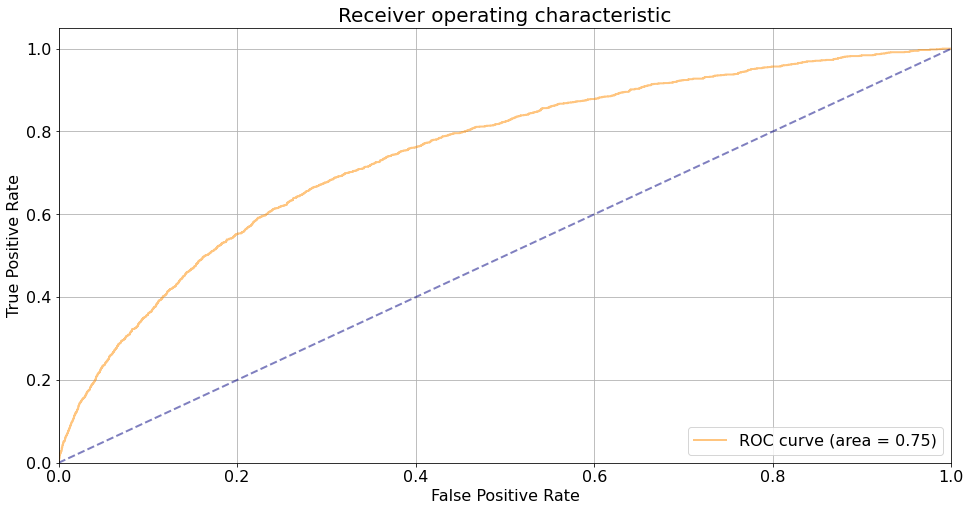

In [48]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

# Итрепретация модели

#### Необходимость данного этапа обуславливается отбором действительно необходимых фичей для дальйнейшего обучения и исключением шумовых

#### Также необходимостью объяснить заказчику/начальнику/руководителю/и т.д. как модель понимает данные, почему выделяет одни признаке на фоне остальных и некую понятную констатацию закономерностей

## PredictionValuesChange

In [84]:
df = pd.DataFrame(model_after_grid_search.get_feature_importance(prettified=True))

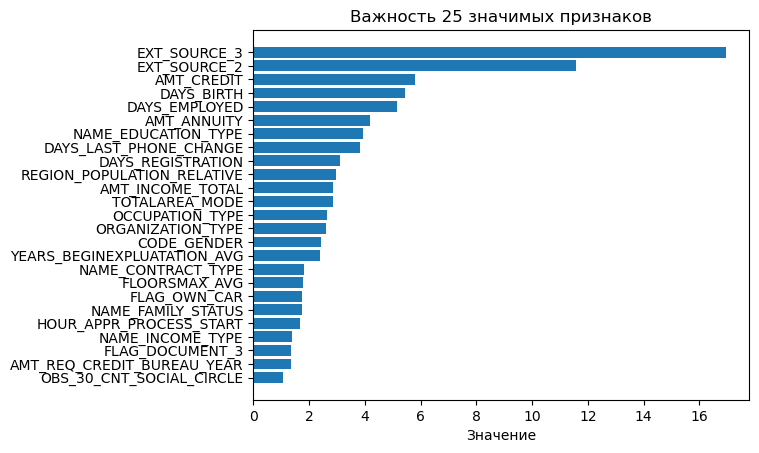

In [124]:
fig, ax = plt.subplots()
ax.barh(df['Feature Id'].iloc[0:25], df['Importances'].iloc[0:25], align='center')
ax.set_yticks(df['Feature Id'].iloc[0:25])
ax.invert_yaxis()  
ax.set_xlabel('Значение')
ax.set_title('25 значимых признаков')
plt.show()

#### Для каждого объекта PredictionValuesChange показывает, насколько в среднем изменяется прогноз при изменении значения объекта. Чем больше значение важности, тем больше в среднем изменение значения прогноза, если эта функция будет изменена.

#### Значения важности признаков нормализованы так, чтобы сумма важностей всех функций была равна 100

#### Мне бы не хотелось уверено увтреждать, что данные признаки действительно являются важными с учетом всего сказаннаого и продемострированного о предсказательной способности модели. Также, я бы не стал основываться только на данном методе расчета (предположим, что моя модель является хорошо обученой), а взглянул бы на совокупность результатов разных методов подсчета важности признаков на таргет

## Shap

#### Чтобы понять, почему какой-то объект был предсказан таким образом, можно посмотреть вклад других фичей в предсказание выбраного
#### Красные фичи - двигают предсказание в положиетльную сторону, т.е. они увиличивают вероятность того, что для данного объекта (заемщика) будет предсказан не возрат средств/ проблемы по платежам
#### Синие фичи - снижают вероятность

In [182]:
from shap import TreeExplainer

In [206]:
shap_values = model_after_grid_search.get_feature_importance(eval_pool, fstr_type='ShapValues') 
explainer = shap.TreeExplainer(model_after_grid_search)
shap_values = explainer.shap_values(eval_pool)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[3,:], X_test.iloc[3,:])

#### Чтобы получить представление о том, какие признаки наиболее важны для модели, можно построить значения SHAP для каждого признака с каждым объектом

#### График состоит из точек. Каждая точка  - обучающий объект выбокри (заемщик)
#### Для точек, расположенных справа от вертикальной черты, для них вклад от данной фичи положительный,т.е. они увиличивают вероятность того, что для данного объекта (заемщика) будет предсказан не возрат средств/ проблемы по платежам
#### Чем шыре полоска, чем больший общий вклад внесла фича для совокуности объектов
#### Цвет представляет значение фичи (красный высокое, синий низкое)
#### Серый цвет представляет собой категориальные значения, которые не могут быть увеличены или уменьшены. Но специалисты по сопровождению пакетов работают над этим. (пока что это едиственное объясниние, которое я смог найти)

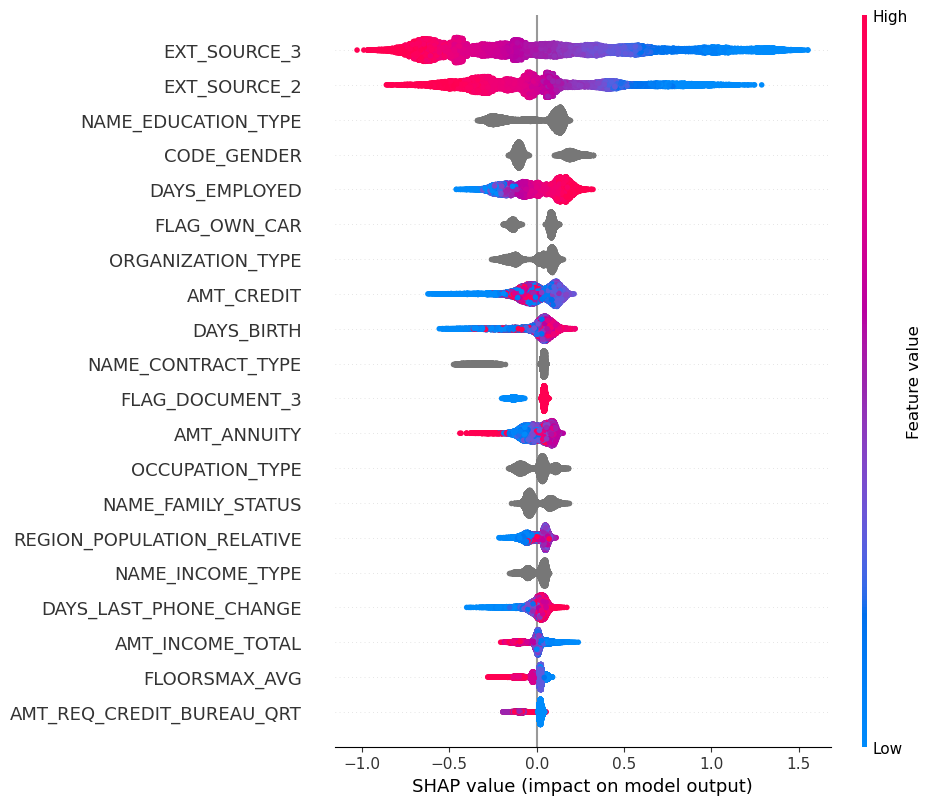

In [205]:
shap.summary_plot(shap_values, X_test)

#### Чтобы посмотреть влияние столбцов не для 1 объекта, а для N, можно построить следущий график (суть цветов как и для 1 графика визуализаций shap)

In [204]:
X_small = X_test.iloc[0:100]
shap_small = shap_values[:100]
shap.force_plot(expected_value,shap_small,X_small)

### Также, можно использовать посмотреть что говорит LIME и другие методы, но это уже будет расмотрено в рамках дипломной работы. Сейчас, для "плохой" модели, углубленная инпрепретация, как мне кажется, не столь важна